# Desafio 2: Classificação de Imagens com Deep Learning

Joab Morais Varela

## Objetivo
Desenvolver, treinar e avaliar comparativamente pelo menos dois modelos de Deep  
Learning para um problema de classificação de imagens multiclclasse, a fim de  
determinar a arquitetura mais eficaz e gerar uma análise conclusiva sobre os  
resultados.

A resolução deste desafio foi estruturada em duas etapas, com o intuito de diversificar os experimentos e identificar potenciais dificuldades que se assemelham a situações reais de aplicação. Em cada etapa, é utilizado um conjunto de dados distinto: o primeiro, mais robusto e abrangente, é o [``Intel Image Classification``](https://www.kaggle.com/datasets/puneet6060/intel-image-classification); o segundo, mais limitado em tamanho e variabilidade, é o [``Jellyfish Types``](https://www.kaggle.com/datasets/anshtanwar/jellyfish-types), o que torna o processo de treinamento mais desafiador e suscetível a problemas de generalização.


## Importando bibliotecas

In [88]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
import os

## Definindo Funções uteis para plots
(Para uma boa vizualização, mantenha esta aba minimizada)

In [89]:
def plot_de_imagens(dataset, class_names):

    plt.figure(figsize=(15, 8))
    shown_classes = set()
    class_to_img = {}

    # Itera sobre o dataset até encontrar uma imagem de cada classe
    for images, labels in dataset.unbatch():
        label = int(labels.numpy())
        class_name = class_names[label]
        if class_name not in shown_classes:
            shown_classes.add(class_name)
            class_to_img[class_name] = images.numpy().astype("uint8")
        if len(shown_classes) == len(class_names):
            break

    # Plotar uma imagem por classe
    for idx, class_name in enumerate(class_names):
        plt.subplot(2, (len(class_names) + 1) // 2, idx + 1)
        plt.imshow(class_to_img[class_name])
        plt.title(class_name, fontsize=12)
        plt.axis("off")

    plt.suptitle("Exemplo de Imagem por Classe", fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_history(history, title):
    plt.style.use('ggplot')
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5)) # Aumentando um pouco o tamanho
    fig.suptitle(title, fontsize=16, fontweight='bold') # Título geral mais proeminente

    # Para Acurácia
    ax1 = axes[0]
    ax1.plot(history.history['accuracy'], label='Treino', marker='o', linestyle='-', linewidth=2, markersize=4)
    ax1.plot(history.history['val_accuracy'], label='Validação', marker='s', linestyle='--', linewidth=2, markersize=4)
    
    ax1.set_title('Acurácia por Época', fontsize=14)
    ax1.set_xlabel('Épocas', fontsize=12)
    ax1.set_ylabel('Acurácia', fontsize=12)
    ax1.legend(fontsize=10, loc='lower right')
    ax1.grid(True, linestyle=':', alpha=0.7) # Grade mais suave
    
    # Para Loss
    ax2 = axes[1]
    ax2.plot(history.history['loss'], label='Treino', marker='o', linestyle='-', linewidth=2, markersize=4)
    ax2.plot(history.history['val_loss'], label='Validação', marker='s', linestyle='--', linewidth=2, markersize=4)
    
    ax2.set_title('Loss (Perda) por Época', fontsize=14)
    ax2.set_xlabel('Épocas', fontsize=12)
    ax2.set_ylabel('Loss (Perda)', fontsize=12)
    ax2.legend(fontsize=10, loc='upper right')
    ax2.grid(True, linestyle=':', alpha=0.7) 
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_confusion(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(title)
    plt.show()
    

def plot_roc_curve(model, test_ds, class_names, title="Curva ROC"):

    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_pred_prob = model.predict(test_ds)
    
    # Binariza os rótulos verdadeiros (necessário para multiclasses)
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = y_true_bin.shape[1]

    # Calcula curvas ROC e AUC para cada classe
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcula média micro e macro
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Média macro
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (área = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average ROC (área = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Classe {class_names[i]} (área = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Falsos Positivos')
    plt.ylabel('Verdadeiros Positivos')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

## Primeiro caso: Intel_image

## Preparação de dados

Definindo variável de diretorio e alguns hiperparâmetros

In [90]:
train_dir = "DATA/intel_image/seg_train/seg_train/"
test_dir = "DATA/intel_image/seg_test/seg_test"

img_size = (150, 150)
batch_size = 32
seed = 42


Carregado dados, e separando os dados de treino, validação e teste.

In [91]:
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Visualizando alguns itens do dataset, 1 item para cada classe. 

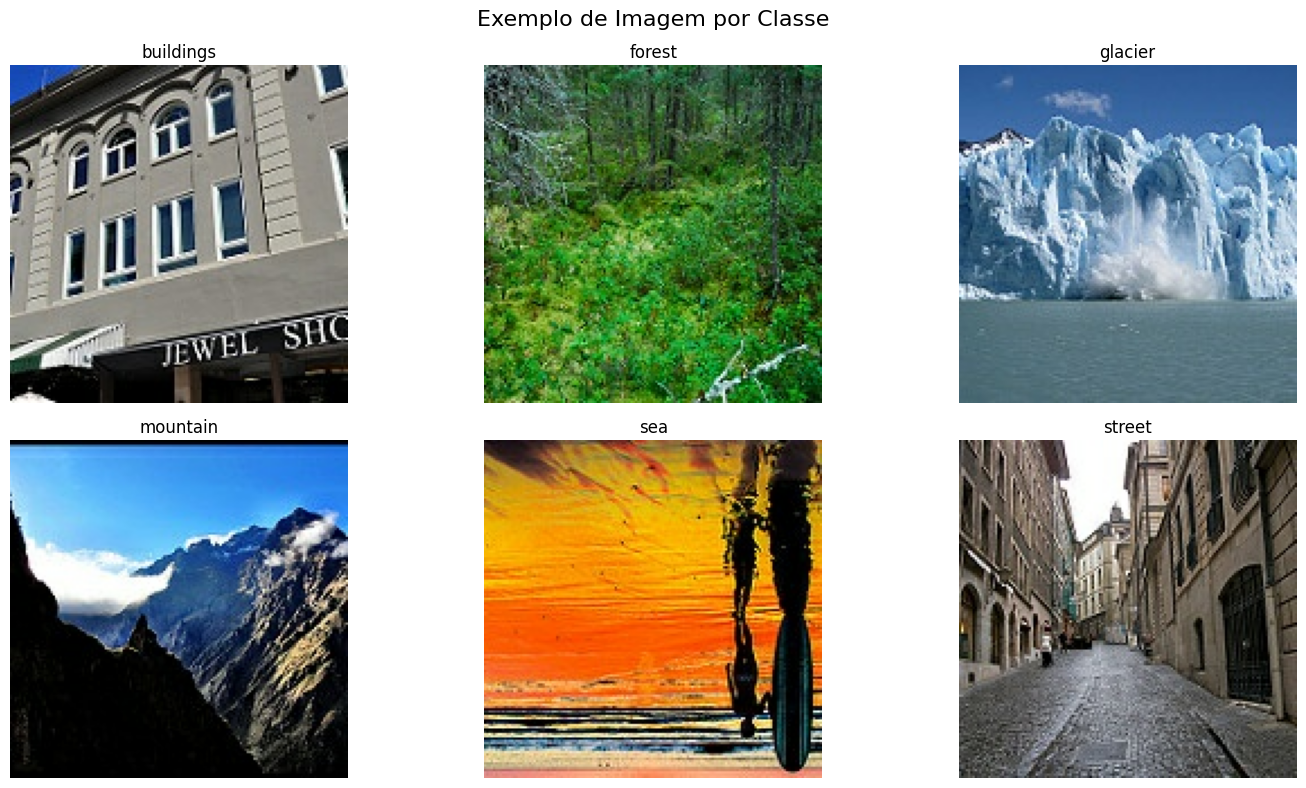

In [92]:
plot_de_imagens(train_ds,class_names)

## Definição e treinamento dos modelos

**MODELO A**: Criando, Compilando e Treinando o modelo CNN simples

- Como o dataset da intel_image possui uma quantidade consideravel de imagens(25k),  
mesmo um modelo simples como esse treinado com uma baixa quantidade epocas, pode resultar em uma boa precisão

In [93]:
simples_cnn = models.Sequential([
    layers.Rescaling(1./255, input_shape=img_size + (3,)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

simples_cnn.compile(optimizer=Adam(1e-3),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

print("\nTreinando CNN Simples...")
history_simple = simples_cnn.fit(train_ds, validation_data=val_ds, epochs=10)


Treinando CNN Simples...
Epoch 1/10


c:\Users\joabm\Documents\PROJETO SENAI CDC\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 221ms/step - accuracy: 0.5704 - loss: 1.1109 - val_accuracy: 0.6565 - val_loss: 0.8673
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 208ms/step - accuracy: 0.7100 - loss: 0.7711 - val_accuracy: 0.7819 - val_loss: 0.6244
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 207ms/step - accuracy: 0.7842 - loss: 0.6003 - val_accuracy: 0.7894 - val_loss: 0.5899
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 206ms/step - accuracy: 0.8202 - loss: 0.5007 - val_accuracy: 0.8118 - val_loss: 0.5505
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 207ms/step - accuracy: 0.8556 - loss: 0.4011 - val_accuracy: 0.8161 - val_loss: 0.5416
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 208ms/step - accuracy: 0.8813 - loss: 0.3331 - val_accuracy: 0.7912 - val_loss: 0.6523
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 75s 213ms/step - accuracy: 0.9056 - loss: 0.2647 - val_accuracy: 0.8083 - val_loss: 0.6815
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 207ms/step - accuracy: 0.9219 - loss: 0.2171 - val

**MODELO B**: Criando, Compilando e Treinando o modelo mais complexo utilizando a Arquitetura `DenseNet121`

Embora o modelo simples tenha apresentado um desempenho satisfatório em termos de acurácia, os benefícios de empregar uma arquitetura mais complexa, como a `DenseNet121`, podem não ser imediatamente evidentes. No entanto, essa abordagem permite explorar uma representação mais profunda e rica das características dos dados, potencialmente resultando em uma melhor capacidade de generalização e maior robustez frente a variações no conjunto de teste.


In [94]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=img_size + (3,))
base_model.trainable = False  # Congela camadas base

transfer_model = models.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

transfer_model.compile(optimizer=Adam(1e-4),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

print("\nTreinando DenseNet121 (Transfer Learning)...")
history_transfer = transfer_model.fit(train_ds, validation_data=val_ds, epochs=10)


Treinando DenseNet121 (Transfer Learning)...
Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 204s 558ms/step - accuracy: 0.7593 - loss: 0.6597 - val_accuracy: 0.8895 - val_loss: 0.3250
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 188s 535ms/step - accuracy: 0.8648 - loss: 0.3630 - val_accuracy: 0.9009 - val_loss: 0.2813
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 190s 541ms/step - accuracy: 0.8876 - loss: 0.3117 - val_accuracy: 0.9052 - val_loss: 0.2665
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 183s 521ms/step - accuracy: 0.8930 - loss: 0.2829 - val_accuracy: 0.9041 - val_loss: 0.2612
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 184s 524ms/step - accuracy: 0.9005 - loss: 0.2602 - val_accuracy: 0.9102 - val_loss: 0.2515
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 183s 523ms/step - accuracy: 0.9068 - loss: 0.2488 - val_accuracy: 0.9073 - val_loss: 0.2489
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 183s 522ms/step - accuracy: 0.9129 - loss: 0.2326 - val_accuracy: 0.9116 - val_loss: 0.2423
Epoch 8/10
351/351 ━━━━━━━━━━━

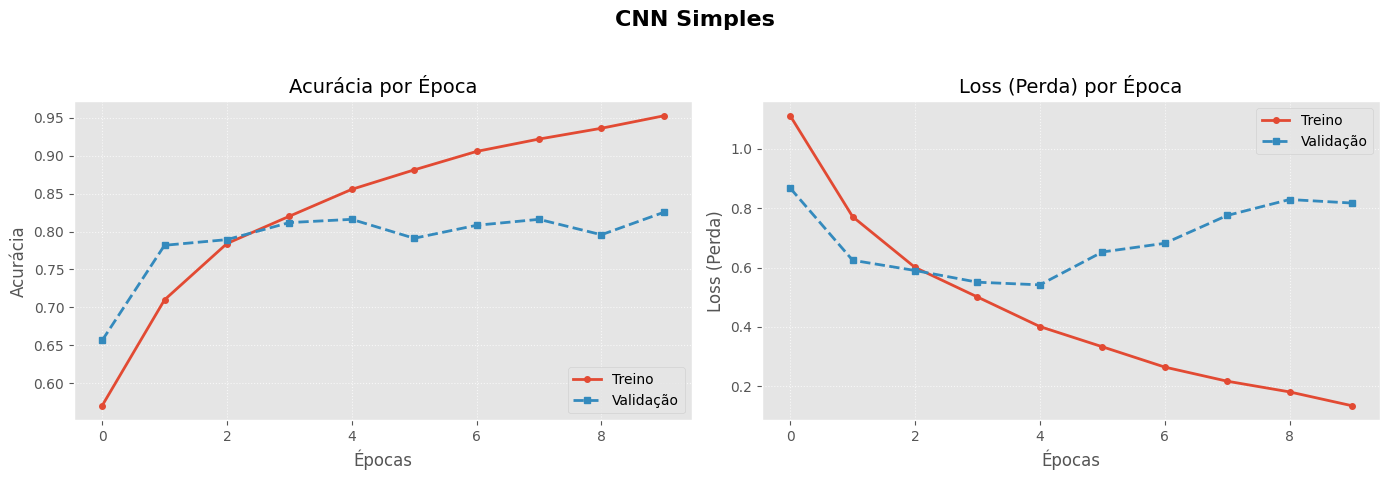

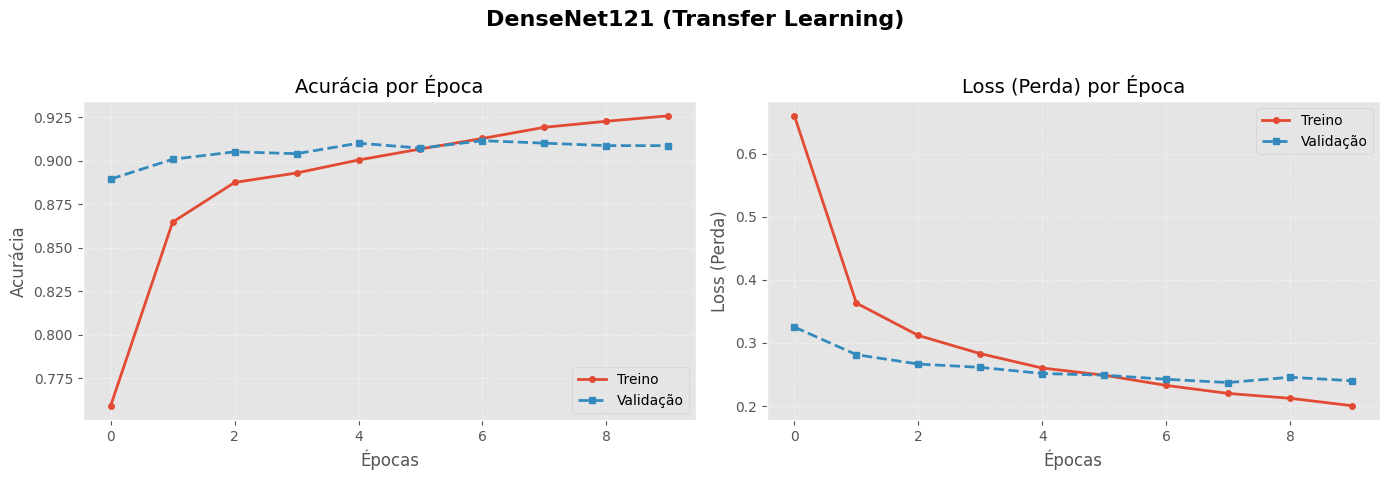

In [95]:

plot_history(history_simple, "CNN Simples")
plot_history(history_transfer, "DenseNet121 (Transfer Learning)")

Ao analisar as curvas de desempenho, torna-se evidente a superioridade do **Modelo B**. Observa-se que a curva de *loss* do **Modelo A** apresenta indícios característicos de *overfitting*, refletindo uma discrepância crescente entre o erro de treinamento e o de validação. Em contraste, o **Modelo B** demonstra um comportamento mais estável e consistente, sugerindo melhor capacidade de generalização e menor propensão ao ajuste excessivo dos dados de treinamento.


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 471ms/step


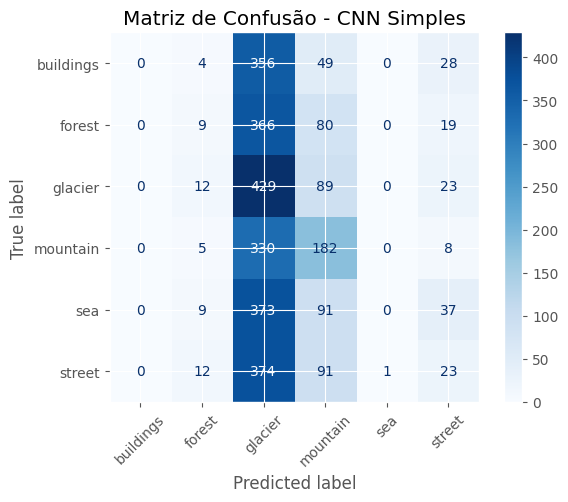

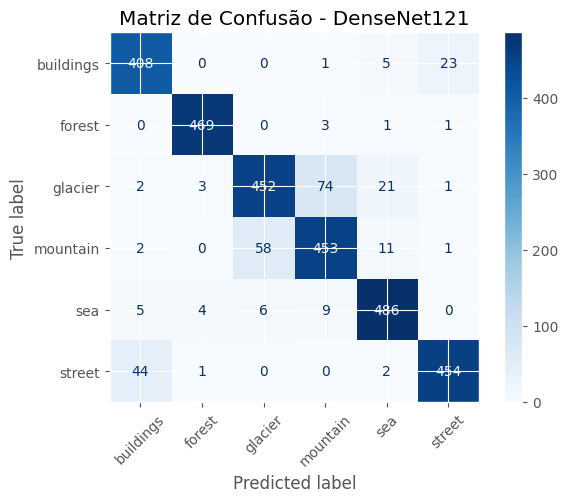

In [96]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)

y_pred_simple = np.argmax(simple_cnn.predict(test_ds), axis=1)
y_pred_transfer = np.argmax(transfer_model.predict(test_ds), axis=1)

plot_confusion(y_true, y_pred_simple, class_names, "Matriz de Confusão - CNN Simples")
plot_confusion(y_true, y_pred_transfer, class_names, "Matriz de Confusão - DenseNet121")

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step


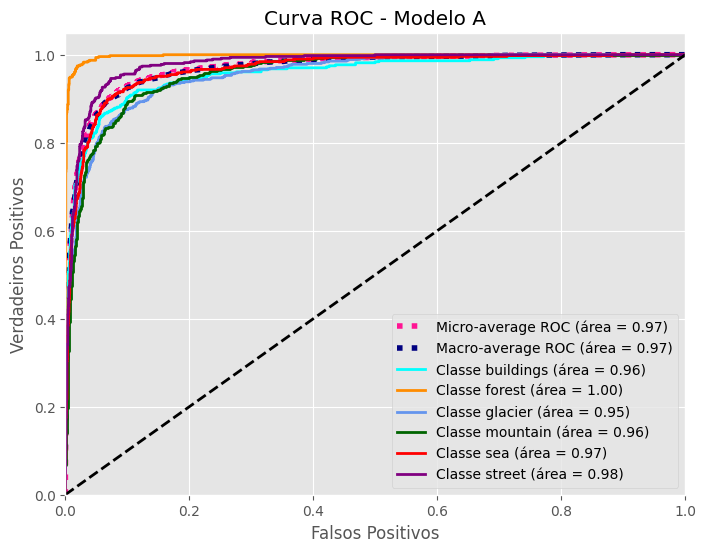

94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 435ms/step


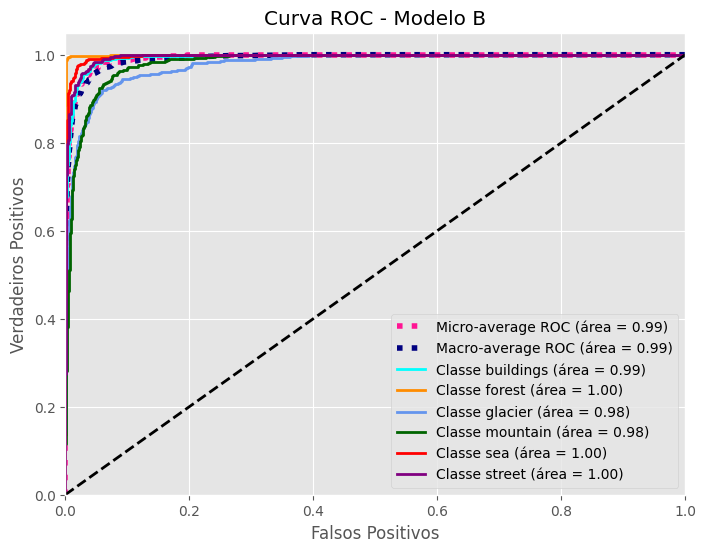

In [97]:
plot_roc_curve(simples_cnn, test_ds,class_names, title='Curva ROC - Modelo A')
plot_roc_curve(transfer_model, test_ds,class_names, title='Curva ROC - Modelo B')

In [98]:
loss_simples, acc_simples = simples_cnn.evaluate(test_ds, verbose=0)
loss_transfer, acc_transfer = transfer_model.evaluate(test_ds, verbose=0)

print(f"\nRESULTADOS FINAIS:")
print(f"CNN Simples -> Acurácia: {acc_simples:.4f} | Loss: {loss_simples:.4f}")
print(f"DenseNet121 -> Acurácia: {acc_transfer:.4f} | Loss: {loss_transfer:.4f}")


RESULTADOS FINAIS:
CNN Simples -> Acurácia: 0.8210 | Loss: 0.7820
DenseNet121 -> Acurácia: 0.9073 | Loss: 0.2515


## Segundo caso: jellyfish-types

Neste sugundo caso apenas repetiremos os passos anteriores com o novo dataset.

In [99]:
train_dir = "DATA/jellyfish-types/Train_Test_Valid/Train"
test_dir = "DATA/jellyfish-types/Train_Test_Valid/test"
valid_dir = "DATA/jellyfish-types/Train_Test_Valid/valid"

img_size = (150, 150)
batch_size = 32
seed = 42

In [100]:
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)
val_ds = image_dataset_from_directory(
    valid_dir,
    image_size=img_size,
    batch_size=batch_size
)
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

Found 900 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.
Classes: ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


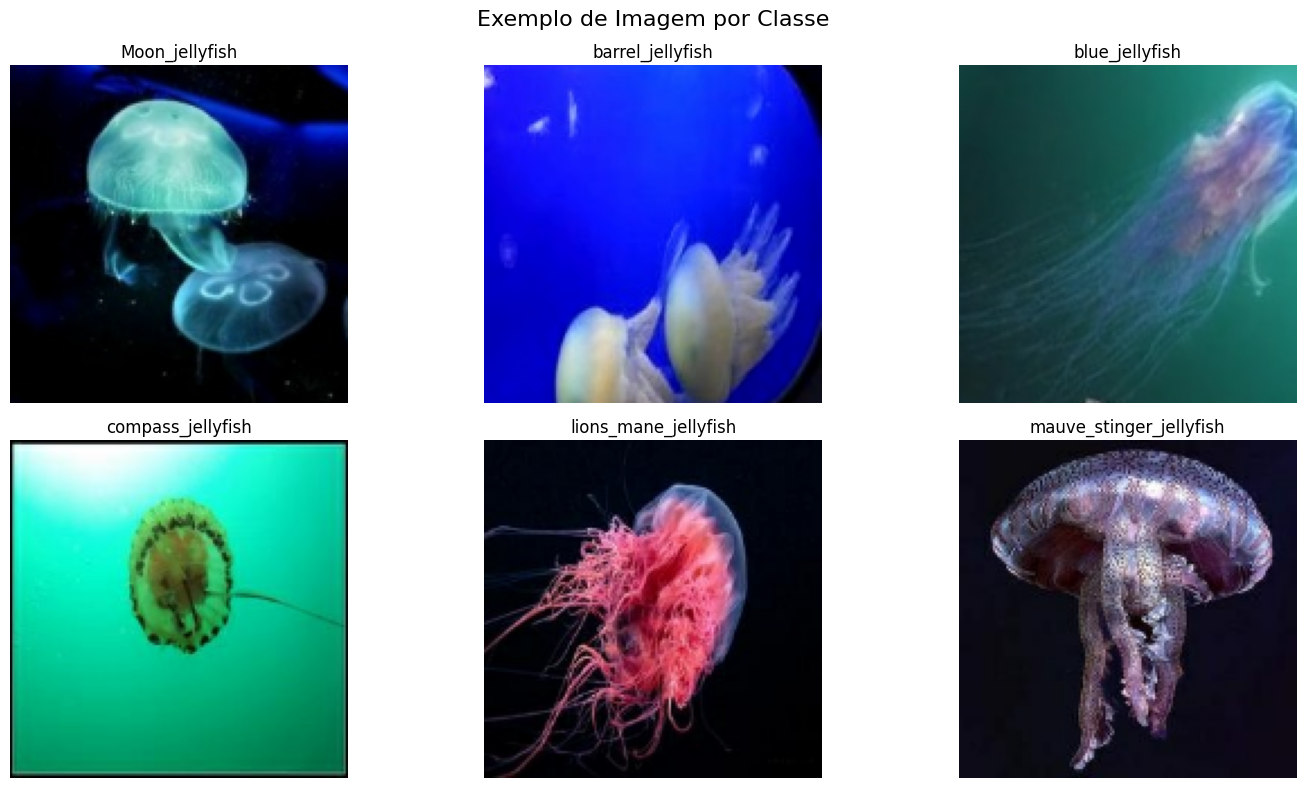

In [101]:
plot_de_imagens(train_ds,class_names)

In [102]:
simples_cnn = models.Sequential([
    layers.Rescaling(1./255, input_shape=img_size + (3,)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

simples_cnn.compile(optimizer=Adam(1e-3),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

print("\nTreinando CNN Simples...")
history_simple = simples_cnn.fit(train_ds, validation_data=val_ds, epochs=10)


Treinando CNN Simples...
Epoch 1/10


c:\Users\joabm\Documents\PROJETO SENAI CDC\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.2556 - loss: 1.7718 - val_accuracy: 0.3846 - val_loss: 1.3973
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.4411 - loss: 1.4046 - val_accuracy: 0.4103 - val_loss: 1.3485
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.4889 - loss: 1.2457 - val_accuracy: 0.4872 - val_loss: 1.2719
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.5978 - loss: 1.0501 - val_accuracy: 0.4872 - val_loss: 1.2445
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.6656 - loss: 0.8876 - val_accuracy: 0.4872 - val_loss: 1.2993
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.7000 - loss: 0.8049 - val_accuracy: 0.4103 - val_loss: 1.5687
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.7889 - loss: 0.5862 - val_accuracy: 0.4615 - val_loss: 1.7061
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.8233 - loss: 0.4675 - val_accuracy: 0.4359 - val_

In [103]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=img_size + (3,))
base_model.trainable = False  # Congela camadas base

transfer_model = models.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

transfer_model.compile(optimizer=Adam(1e-4),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

print("\nTreinando DenseNet121 (Transfer Learning)...")
history_transfer = transfer_model.fit(train_ds, validation_data=val_ds, epochs=10)


Treinando DenseNet121 (Transfer Learning)...
Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 539ms/step - accuracy: 0.2478 - loss: 2.1622 - val_accuracy: 0.5128 - val_loss: 1.4729
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 447ms/step - accuracy: 0.4844 - loss: 1.4394 - val_accuracy: 0.5897 - val_loss: 1.1808
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 474ms/step - accuracy: 0.6033 - loss: 1.0852 - val_accuracy: 0.6154 - val_loss: 1.1199
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 425ms/step - accuracy: 0.6822 - loss: 0.8648 - val_accuracy: 0.6154 - val_loss: 1.0471
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 428ms/step - accuracy: 0.7322 - loss: 0.7429 - val_accuracy: 0.6410 - val_loss: 0.9920
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 418ms/step - accuracy: 0.7811 - loss: 0.6174 - val_accuracy: 0.6667 - val_loss: 0.9537
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 421ms/step - accuracy: 0.8011 - loss: 0.5597 - val_accuracy: 0.6667 - val_loss: 0.9515
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 422ms/ste

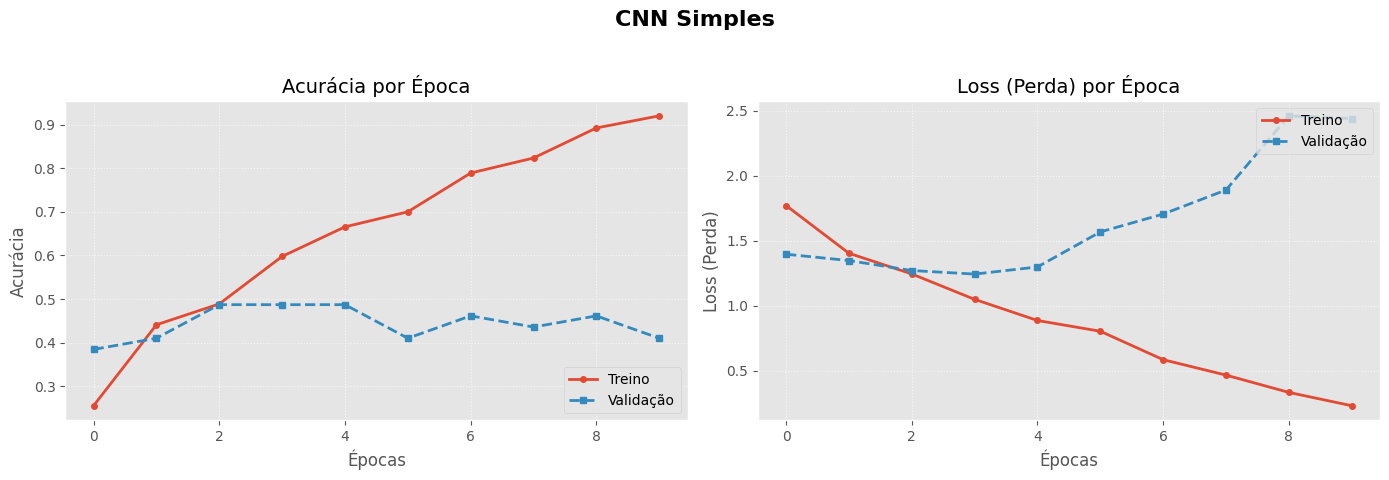

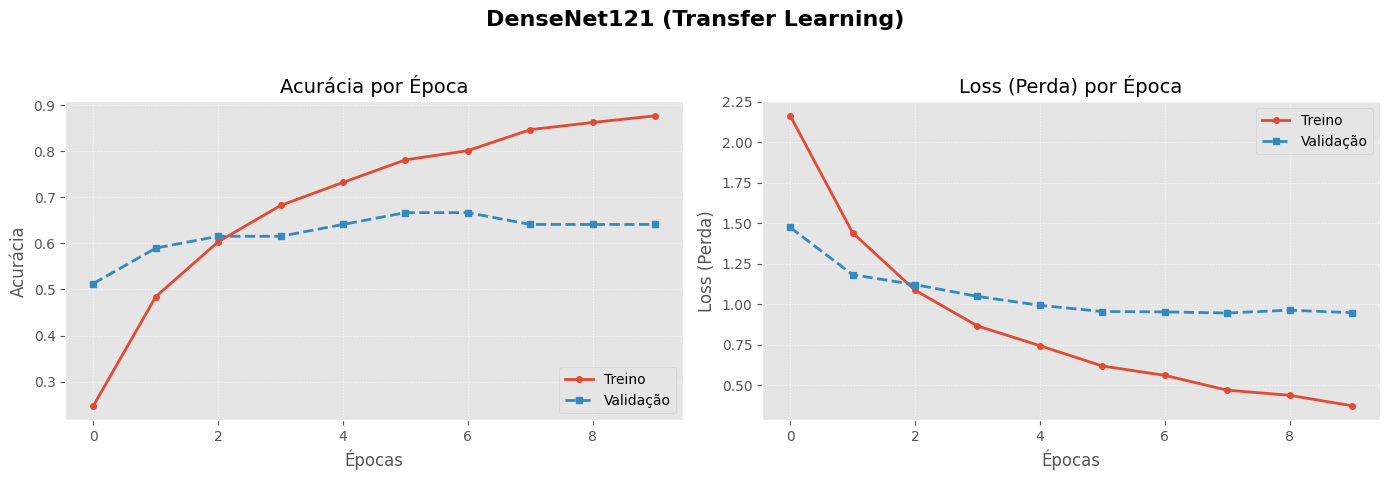

In [104]:
plot_history(history_simple, "CNN Simples")
plot_history(history_transfer, "DenseNet121 (Transfer Learning)")

A partir da análise das curvas, observa-se que mesmo modelos mais complexos podem apresentar indícios de overfitting quando treinados em conjuntos de dados com baixa diversidade. Ainda assim, os resultados obtidos permanecem significativamente superiores aos do modelo simples, evidenciando que a maior profundidade e capacidade representacional do modelo complexo contribuem positivamente para o desempenho geral, mesmo em cenários de limitação dos dados (A matriz de confusão mostra claramente a superioridade do modelo mais complexo sobre o simples).

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step


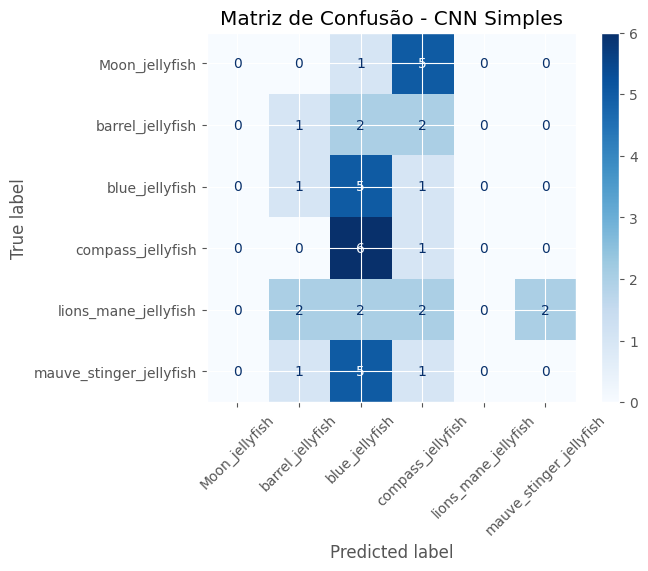

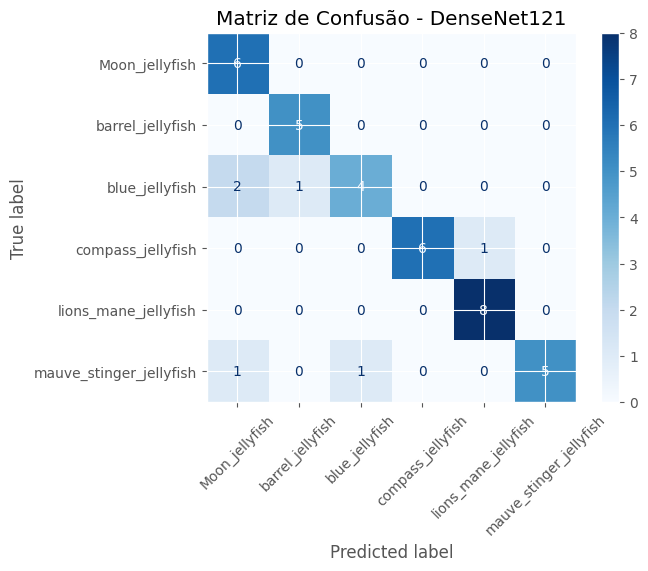

In [105]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)

y_pred_simple = np.argmax(simple_cnn.predict(test_ds), axis=1)
y_pred_transfer = np.argmax(transfer_model.predict(test_ds), axis=1)

plot_confusion(y_true, y_pred_simple, class_names, "Matriz de Confusão - CNN Simples")
plot_confusion(y_true, y_pred_transfer, class_names, "Matriz de Confusão - DenseNet121")

In [106]:
loss_simples, acc_simples = simples_cnn.evaluate(test_ds, verbose=0)
loss_transfer, acc_transfer = transfer_model.evaluate(test_ds, verbose=0)

print(f"RESULTADOS FINAIS:")
print(f"CNN Simples -> Acurácia: {acc_simples:.4f} | Loss: {loss_simples:.4f}")
print(f"DenseNet121 -> Acurácia: {acc_transfer:.4f} | Loss: {loss_transfer:.4f}")

RESULTADOS FINAIS:
CNN Simples -> Acurácia: 0.5500 | Loss: 2.3374
DenseNet121 -> Acurácia: 0.8500 | Loss: 0.4646


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


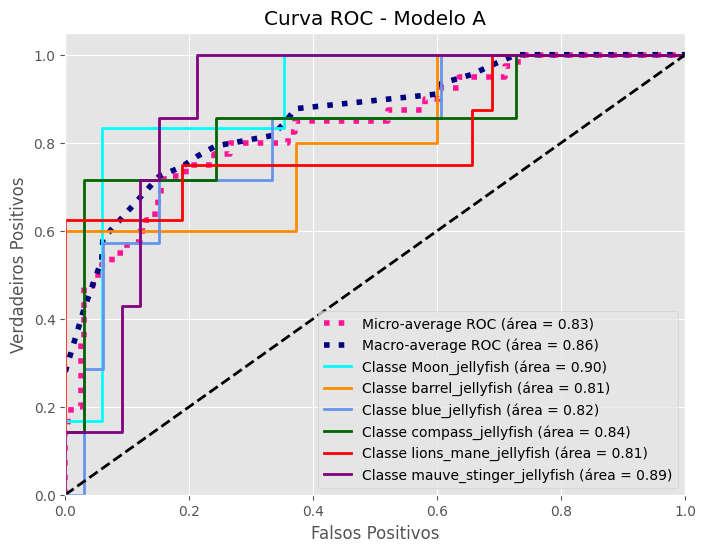

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


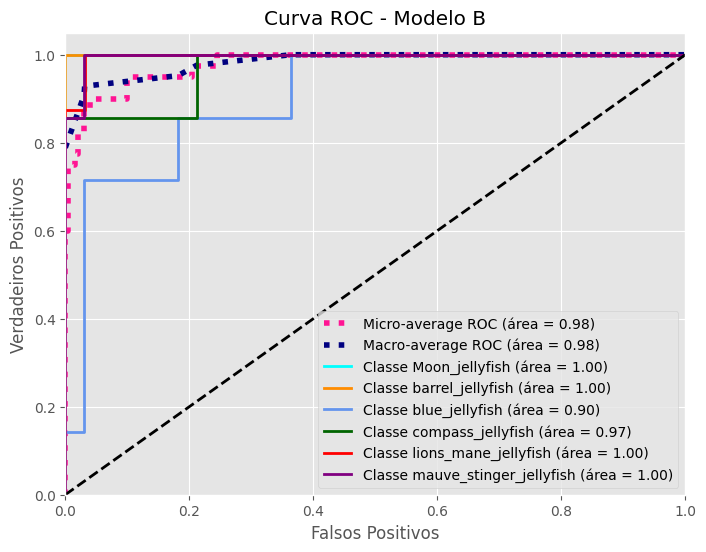

In [107]:
plot_roc_curve(simples_cnn, test_ds,class_names, title='Curva ROC - Modelo A')
plot_roc_curve(transfer_model, test_ds,class_names, title='Curva ROC - Modelo B')

## Texto de Análise

A solução proposta neste trabalho é composta por dois estudos de caso distintos, ambos voltados à análise comparativa do desempenho de diferentes modelos sob condições semelhantes. Como o principal objetivo é avaliar e comparar o comportamento dos modelos frente a cada dataset, todos os hiperparâmetros foram mantidos constantes entre os experimentos, garantindo a equidade das comparações.



Para o **primeiro caso**, no qual foi utilizado o dataset [`Intel Image Classification`](https://www.kaggle.com/datasets/puneet6060/intel-image-classification), foram empregados dois modelos de CNN. O **Modelo A**, também denominado CNN simples, apresenta uma arquitetura composta apenas por camadas básicas e de baixa profundidade. Ainda assim, o desempenho obtido na classificação dos dados de teste foi de aproximadamente $80\%$, superando as expectativas diante da simplicidade do modelo. Entretanto, ao analisar as curvas de acurácia e loss, é possível observar características que evidenciam overfitting sobre os dados de treino. A matriz de confusão reforça essa inconsistência, uma vez que se nota a presença de densidades elevadas fora da diagonal principal. Por outro lado, a curva ROC do Modelo A indica resultados muito satisfatórios: o Macro-average ROC (área = $0.97$) e o Micro-average ROC (área = $0.97$) sugerem uma boa capacidade de discriminação, significativamente superior a uma classificação aleatória (linha tracejada em $0.5$).

Já para o **Modelo B**, observa-se uma melhora evidente tanto nos valores finais de acurácia e loss para os dados de treino, quanto para os dados de teste. As curvas indicam uma forte semelhança entre os resultados de treino e validação, apresentando apenas um leve distanciamento nas épocas finais. A matriz de confusão demonstra o comportamento esperado de um bom modelo, com maior densidade concentrada nos elementos da diagonal principal e distribuição mais uniforme. A acurácia do modelo nos dados de teste foi de aproximadamente $90\%$, superando o desempenho obtido pelo Modelo A. A curva ROC também apresentou um comportamento excelente, com valores de macro e micro-average próximos de 1, o que indica uma capacidade de classificação bastante robusta. No entanto, melhorias adicionais ainda podem ser alcançadas por meio da aplicação de métodos de regularização e de um ajuste mais refinado dos hiperparâmetros.

Para o **segundo caso**, aplicaram-se as mesmas arquiteturas de modelos, porém sobre um novo dataset ([``Jellyfish Types``](https://www.kaggle.com/datasets/anshtanwar/jellyfish-types)). Todo o processo experimental seguiu o mesmo procedimento do caso anterior, diferenciando-se apenas pelo conjunto de dados, que é reduzido: composto por 6 classes, 900 imagens para treino, 40 para teste e 40 para validação.

O **Modelo A** apresentou um desempenho consideravelmente aquém do ideal, evidenciando que CNNs simples não lidam bem com volumes reduzidos de dados. A acurácia nos dados de teste foi baixa (cerca de $50\%$), com clara presença de overfitting. O espalhamento da densidade na matriz de confusão reforça o baixo desempenho, e, embora a curva ROC apresente um comportamento aceitável, sua comparação com os resultados do primeiro caso confirma a limitação do modelo.

Já o **Modelo B** demonstrou superioridade em relação ao Modelo A, destacando sua robustez de classificação, mesmo em cenários com menor volume de dados. Ainda assim, ao compará-lo com o mesmo modelo do primeiro caso, observa-se um desempenho inferior. A acurácia nos dados de teste foi de aproximadamente $80\%$, e as curvas de treino e validação indicam características de overfitting. No entanto, devido ao tamanho reduzido do conjunto de teste e validação, esses indicadores tornam-se menos precisos. A matriz de confusão, por sua vez, apresenta características compatíveis com um bom modelo, sugerindo que, apesar da limitação dos dados, o Modelo B mantém um desempenho satisfatório.

Em ambos os casos, o **Modelo B** apresentou superioridade em relação ao Modelo A. No dataset [`Intel Image Classification`](https://www.kaggle.com/datasets/puneet6060/intel-image-classification), fica evidente que o Modelo B é capaz de se ajustar adequadamente à tarefa de classificação, embora ainda demande alguns aprimoramentos, como a aplicação de técnicas de regularização, fine-tuning e uma escolha mais criteriosa dos hiperparâmetros.

Já no **segundo caso**, utilizando o dataset [`Jellyfish Types`](https://www.kaggle.com/datasets/anshtanwar/jellyfish-types), embora o Modelo B tenha apresentado um desempenho razoável, é provável que estejamos utilizando uma ferramenta excessivamente complexa para o tipo de problema. Em outras palavras, a arquitetura empregada pode não ser a mais adequada para um conjunto de dados tão reduzido e de características visuais bem definidas.

Modelos mais simples podem alcançar maior precisão de classificação, desde que as features sejam bem interpretadas e selecionadas. Por exemplo, ao observar que cada classe apresenta padrões de cores bastante específicos, seria possível utilizar níveis de cor como features e empregar uma MLP tradicional para essa tarefa, o que, além de potencialmente melhorar a precisão, traria um custo computacional de treinamento significativamente menor.

Como perspectiva futura, propõe-se a realização de novos experimentos utilizando o modelo de transfer learning DenseNet121, explorando diferentes configurações e práticas, como o uso de data augmentation, especialmente em cenários com datasets reduzidos. Além disso, pretende-se comparar o desempenho do modelo em três situações distintas: utilizando dados originais, aplicando data augmentation e empregando uma MLP baseada em níveis de cor como features. Também se considera relevante a otimização dos hiperparâmetros e o fine-tuning do modelo, visando alcançar um desempenho mais consistente e generalizável.
